### Predicting Football Match Outcomes with Random Forests

## Project Description

The goal of this project is to develop a machine learning model to predict the outcomes of Premier League football matches. I uses historical data from various football matches, including features such as goals scored, goals conceded, venue, opponent, and other match-specific statistics. By employing a Random Forest classifier and regressor, I aim to predict both the outcome (win, draw, loss) and the expected score of a match.



Key Objectives:





1. Build a predictive model using Random Forest for match outcome classification.
2. Predict scores using Random Forest regression for both home and away teams.
3. Evaluate the model using cross-validation and precision metrics to assess its performance.



## Data Preparation and Feature Engineering


First load the dataset and process it to ensure that all necessary features are prepared for model training.

In [ ]:
import pandas as pd

# Load the dataset
matches = pd.read_csv("matches.csv", index_col=0)

# Show the first few rows of the dataset
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,...,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,...,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,...,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,...,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City


## Data Preprocessing

Removing Unnecessary Columns:

Remove the columns "comp" and "notes" as they are not useful for our prediction model. These columns either contain redundant information or irrelevant data for match outcome predictions.

In [ ]:
del matches["comp"]
del matches["notes"]

Converting Date Column:

The date column is converted into a datetime object to allow easier manipulation and extraction of time-related features.

In [ ]:
matches["date"] = pd.to_datetime(matches["date"])

Creating the Target Variable:

We create a target variable target where a win ("W") is represented as 1 and any other result is represented as 0. This binary classification target will be used to predict the outcome of a match (win or not win).


In [ ]:
matches["target"] = (matches["result"] == "W").astype("int")

Feature Engineering:

Several categorical and time-based features are engineered to be used as predictors for the model:





* venue_code: Encodes whether the match is played at home or away.
* opp_code: Encodes the opposing team.
* hour: Extracts the hour from the match time.
*   day_code: Extracts the day of the week from the match date.





In [ ]:
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches["day_code"] = matches["date"].dt.dayofweek

Final Preprocessed Data:

The resulting dataset includes 1389 rows and 30 columns. A snapshot of the processed data is shown below:

In [ ]:
matches

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,fk,pk,pkatt,season,team,target,venue_code,opp_code,hour,day_code
1,2021-08-15,16:30,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,1.9,...,1.0,0.0,0.0,2022,Manchester City,0,0,18,16,6
2,2021-08-21,15:00,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,2.7,...,1.0,0.0,0.0,2022,Manchester City,1,1,15,15,5
3,2021-08-28,12:30,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,3.8,...,0.0,0.0,0.0,2022,Manchester City,1,1,0,12,5
4,2021-09-11,15:00,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,2.9,...,0.0,0.0,0.0,2022,Manchester City,1,0,10,15,5
6,2021-09-18,15:00,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,1.1,...,1.0,0.0,0.0,2022,Manchester City,0,1,17,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2021-05-02,19:15,Matchweek 34,Sun,Away,L,0.0,4.0,Tottenham,0.5,...,0.0,0.0,0.0,2021,Sheffield United,0,0,18,19,6
39,2021-05-08,15:00,Matchweek 35,Sat,Home,L,0.0,2.0,Crystal Palace,0.7,...,1.0,0.0,0.0,2021,Sheffield United,0,1,6,15,5
40,2021-05-16,19:00,Matchweek 36,Sun,Away,W,1.0,0.0,Everton,1.6,...,0.0,0.0,0.0,2021,Sheffield United,1,0,7,19,6
41,2021-05-19,18:00,Matchweek 37,Wed,Away,L,0.0,1.0,Newcastle Utd,0.8,...,1.0,0.0,0.0,2021,Sheffield United,0,0,14,18,2


## Model Training and Testing with Random Forest Classifier

Random Forest Classifier Setup:

A RandomForestClassifier is instantiated with 50 trees (n_estimators=50) and a minimum sample split of 10. The random_state=1 ensures reproducibility of results.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
import pandas as pd
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

Data Split and Training:

We split the dataset into a training set and a testing set based on the match date. All matches before January 1, 2022, are used for training, while matches after this date are used for testing. This ensures that the model is trained on historical data and tested on unseen matches.

Training Data: All matches before January 1, 2022 (approx. 80% of data)

Testing Data: All matches after January 1, 2022 (approx. 20% of data)

In [ ]:
train = matches[matches["date"] < '2022-01-01']
test = matches[matches["date"] > '2022-01-01']

I have created a bar chart to visually show the number of matches in the training and testing datasets. This helps illustrate the data split.

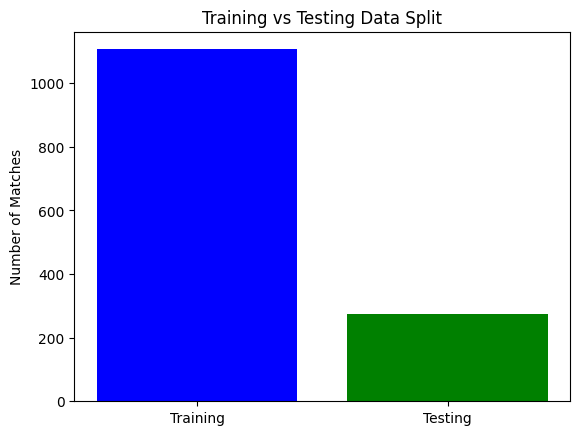

In [ ]:
import matplotlib.pyplot as plt

train_size = len(train)
test_size = len(test)
plt.bar(['Training', 'Testing'], [train_size, test_size], color=['blue', 'green'])
plt.title("Training vs Testing Data Split")
plt.ylabel("Number of Matches")
plt.show()


Feature Selection:

The model uses the following features as predictors for match outcomes:


*   venue_code: Whether the match is home or away.
*   opp_code: The opposing team.
*   hour: The time of the match.
*   day_code: The day of the week.


In [ ]:
predictors = ["venue_code", "opp_code", "hour", "day_code"]
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

Making Predictions:

The trained Random Forest model is used to predict the outcomes of the test set matches.

In [ ]:
preds = rf.predict(test[predictors])

Evaluating Model Performance:

We evaluate the performance of the model using accuracy and precision.


1.   Accuracy Score: Measures the percentage of correct predictions out of all predictions.
2.   Precision Score: Measures the proportion of positive predictions (wins) that were actually correct.

Accuracy gives a general idea of model performance, while precision focuses on how well the model predicts wins.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score

# Calculate accuracy
error = accuracy_score(test["target"], preds)
print(f"Model Accuracy: {error * 100:.2f}%")

# Calculate precision
precision = precision_score(test["target"], preds)
print(f"Model Precision: {precision * 100:.2f}%")


Model Accuracy: 61.23%
Model Precision: 47.46%


Confusion Matrix:

The confusion matrix shows how the model performs in terms of predicting wins (1) and non-wins (0). It helps in identifying false positives and false negatives.

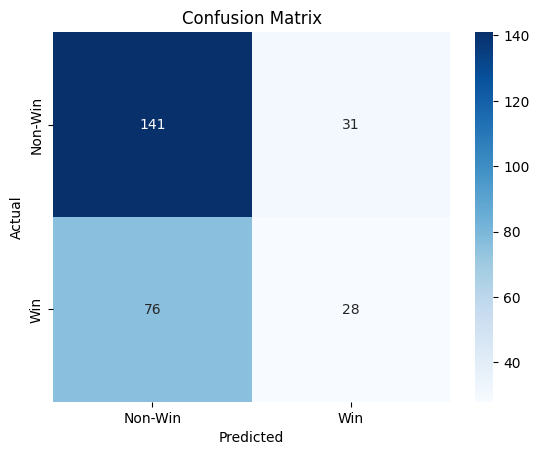

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(test["target"], preds)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Win", "Win"], yticklabels=["Non-Win", "Win"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Rolling Averages for Match Statistics

In this section, we calculate rolling averages for various match statistics to capture recent performance trends. Rolling averages allow us to use data from the last 3 matches to predict the outcome of the current match, which is a valuable feature when modelling sports data.



Rolling Averages Function:

The rolling_averages function computes the rolling mean for selected columns, based on the last 3 matches. The function helps smooth out short-term fluctuations and highlight longer-term trends in performance.


In [ ]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

Columns selected for rolling averages:
gf: Goals for
ga: Goals against
sh: Shots
sot: Shots on target
dist: Distance covered
fk: Free kicks
pk: Penalties scored
pkatt: Penalty attempts

Applying Rolling Averages:

We apply the rolling_averages function to each team using the groupby() function on the team column. This ensures that the rolling averages are calculated independently for each team.

In [ ]:
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('team')

matches_rolling.index = range(matches_rolling.shape[0])

<ipython-input-16-cd9ee8936c1d>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))


Visualising Rolling Averages:

I visualise how rolling averages help smooth out performance data and highlight trends. For example, a plot the rolling average of goals scored (gf_rolling) for a team like Manchester City.

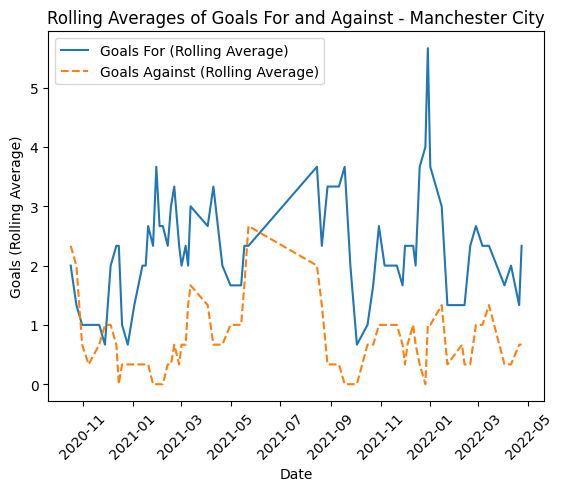

In [ ]:
# Visualising rolling averages for Manchester City
man_city = matches_rolling[matches_rolling["team"] == "Manchester City"]
plt.plot(man_city["date"], man_city["gf_rolling"], label="Goals For (Rolling Average)")
plt.plot(man_city["date"], man_city["ga_rolling"], label="Goals Against (Rolling Average)", linestyle="--")
plt.title("Rolling Averages of Goals For and Against - Manchester City")
plt.xlabel("Date")
plt.ylabel("Goals (Rolling Average)")
plt.legend()
plt.xticks(rotation=45)
plt.show()


Solid Line: Shows the rolling average of goals scored (gf_rolling) over the last 3 matches.

Dashed Line: Shows the rolling average of goals conceded (ga_rolling) over the last 3 matches.

This helps visualise recent performance trends, which are critical for model predictions.

## Making Predictions with Rolling Averages

With rolling averages calculated, we incorporate them into the predictive model to improve accuracy. By feeding in the last 3 matches' performance metrics, the model gets a better idea of each team's recent form.


Prediction Function:

We define a make_predictions function that trains the model on the rolling statistics and evaluates its performance using precision as the evaluation metric.

In [ ]:
# Define a function to make predictions with the rolling average features
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] > '2022-01-01']

    # Fit the Random Forest model
    rf.fit(train[predictors], train["target"])

    # Make predictions on the test set
    preds = rf.predict(test[predictors])

    # Combine actual and predicted values into a single DataFrame
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)

    # Calculate the precision score
    error = precision_score(test["target"], preds)
    return combined, error

# Adding rolling averages to the predictors
combined, error = make_predictions(matches_rolling, predictors + new_cols)


Evaluating Performance:

Using the updated dataset that includes rolling averages, the model achieves a precision score of 62.5%, an improvement over the initial precision of 47.46%. This suggests that the inclusion of recent match trends has made the model more accurate in predicting outcomes.

In [ ]:
print(f"Model Precision with rolling averages: {error * 100:.2f}%")

Model Precision with rolling averages: 62.50%


## Combining Predictions with Match Data and Merging Opponent Data

This section continues from the previous prediction results by adding detailed insights into the model's predictions and merging the data for more in-depth analysis.

Merging Prediction Data with Match Info:

After predicting the match outcomes, we merge the predicted results with the corresponding match details to allow for a more comprehensive review of the predictions.

In [ ]:
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index=True, right_index=True)
combined.head(10)

,actual,predicted,date,team,opponent,result
55,0,0,2022-01-23,Arsenal,Burnley,D
56,1,0,2022-02-10,Arsenal,Wolves,W
57,1,0,2022-02-19,Arsenal,Brentford,W
58,1,1,2022-02-24,Arsenal,Wolves,W
59,1,1,2022-03-06,Arsenal,Watford,W
60,1,1,2022-03-13,Arsenal,Leicester City,W
61,0,1,2022-03-16,Arsenal,Liverpool,L
62,1,0,2022-03-19,Arsenal,Aston Villa,W
63,0,0,2022-04-04,Arsenal,Crystal Palace,L
64,0,0,2022-04-09,Arsenal,Brighton,L


The combined DataFrame now includes columns for the actual and predicted outcomes alongside the match details like date, teams involved, and the final result.

Mapping Teams for Consistency:

To standardise team names and avoid inconsistencies, we use a custom mapping dictionary for certain team names that might have multiple variations in the dataset.

In [ ]:
# Creating a custom dictionary to standardise team names
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {
    "Brighton and Hove Albion": "Brighton",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves"
}
mapping = MissingDict(**map_values)

# Applying the mapping to the team column
combined["new_team"] = combined["team"].map(mapping)

This ensures consistency across the dataset where team names may have different formats (e.g., "Brighton and Hove Albion" is simplified to "Brighton").

Merging Opponent Data:

To analyse the model's predictions in more depth, we merge the predictions of a team and their opponent on the same date. This allows us to compare how the model predicted both teams' outcomes in the same match.

In [ ]:
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])
merged.head()

,actual_x,predicted_x,date,team_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,team_y,opponent_y,result_y,new_team_y
0,0,0,2022-01-23,Arsenal,Burnley,D,Arsenal,0,0,Burnley,Arsenal,D,Burnley
1,1,0,2022-02-10,Arsenal,Wolves,W,Arsenal,0,0,Wolverhampton Wanderers,Arsenal,L,Wolves
2,1,0,2022-02-19,Arsenal,Brentford,W,Arsenal,0,0,Brentford,Arsenal,L,Brentford
3,1,1,2022-02-24,Arsenal,Wolves,W,Arsenal,0,0,Wolverhampton Wanderers,Arsenal,L,Wolves
4,1,1,2022-03-06,Arsenal,Watford,W,Arsenal,0,0,Watford,Arsenal,L,Watford


The merged dataset now includes the actual and predicted outcomes for both the home and away teams in each match.

# Evaluating the Model’s Performance

We now focus on a specific subset of matches where the model predicted one team to win (predicted_x == 1) and the other team to lose (predicted_y == 0). This helps identify cases where the model might have been inconsistent in predicting the outcome for both teams in the same match.

In [ ]:
# Analysing cases where the model predicted one team to win and the other to lose
correct_predictions = merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 0)]["actual_x"].value_counts()

# Display the count of correct and incorrect predictions
print(correct_predictions)


actual_x
1    27
0    13
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import precision_score

# Calculating the precision score for the merged data
y_true = merged['actual_x']
y_pred = merged['predicted_x']
precision = precision_score(y_true, y_pred)

# Displaying the precision score
print(f"Model Precision fron the merged dataset: {precision * 100:.2f}%")

Model Precision fron the merged dataset: 65.22%


Out of 40 matches, the model predicted correctly in 27 matches (where the actual result was a win), and incorrectly in 13 matches (where the actual result was a loss).  The model achieves a final precision score of 65.22%.

# Visualising Precision with Confusion Matrix

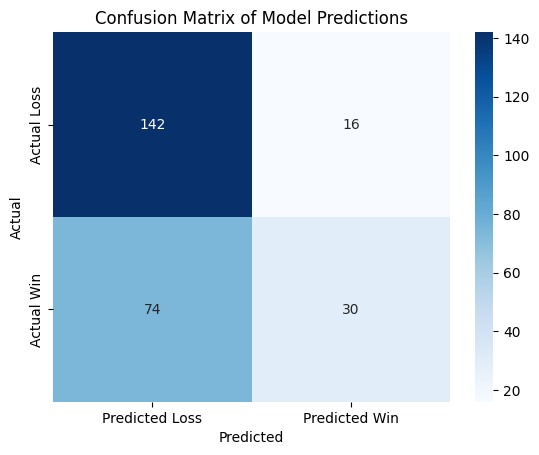

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted Loss", "Predicted Win"], yticklabels=["Actual Loss", "Actual Win"])
plt.title("Confusion Matrix of Model Predictions")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Random Forest with Hyperparameter Tuning and Feature Engineering

In this section, I aim to improve the model's performance by fine-tuning the hyperparameters of the Random Forest model and implementing additional feature engineering techniques. Hyperparameter tuning is essential to ensure the model’s parameters are optimised for better accuracy and precision.



# Import Libraries

First, import all the necessary libraries.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import pandas as pd

# Scaling Function

Scaling ensures that features with larger ranges (such as shots, goals, distance covered) do not dominate those with smaller ranges (like penalty kicks). StandardScaler standardises the features by removing the mean and scaling to unit variance.



In [ ]:
# Scaling function
def scale_features(train, test, predictors):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[predictors])
    test_scaled = scaler.transform(test[predictors])
    return train_scaled, test_scaled

Hyperparameters:


*   n_estimators=200: We increase the number of trees to 200, allowing the model to make more refined decisions based on a larger number of trees.
*   max_depth=10: Limiting the tree depth to 10 helps prevent overfitting by reducing the model's complexity.
*   min_samples_split=5: This prevents the model from creating nodes with very few samples, making it more robust.
*   class_weight={0: 1, 1: 2}: We assign a higher weight to the "win" class to address class imbalance and make the model more sensitive to predicting wins.









# Recent Form Feature

We create a recent_form feature that represents the average of the target variable over the last 5 matches for each team. Capturing the recent form of a team is crucial in sports predictions, as teams on a winning streak are likely to continue performing well.

In [ ]:
# Assuming the target column is named 'target'
matches_rolling["recent_form"] = matches_rolling.groupby("team")["target"].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)


# Rolling Goal Difference Feature

We create a rolling_goal_diff feature that calculates the goal difference over the last 3 matches for each team. By looking at the recent goal difference, we can gain insights into how well a team has been both offensively and defensively.

In [ ]:
# Adding 'rolling goal difference' feature based on last 3 matches
matches_rolling["rolling_goal_diff"] = matches_rolling.groupby("team")["gf"].rolling(window=3, min_periods=1).sum().reset_index(0, drop=True) - matches_rolling.groupby("team")["ga"].rolling(window=3, min_periods=1).sum().reset_index(0, drop=True)


# Adjusted Prediction Function with Hyperparameter Tuning

We create a function to train the Random Forest model with tuned hyperparameters and make predictions.

Hyperparameter Tuning Overview

The Random Forest Classifier can be tuned by adjusting various parameters such as:



*   n_estimators: The number of trees in the forest.
*   max_depth: The maximum depth of the trees.
*   min_samples_split: The minimum number of samples required to split an internal node.
*   class_weight: Used to handle class imbalance by assigning more weight to the minority class (wins).



By adjusting these parameters, we aim to reduce overfitting and improve the generalisation of the model to unseen data.



In [ ]:
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] > '2022-01-01']

    # Ensure all predictors are present
    available_predictors = list(set(predictors) & set(train.columns))

    # Drop any rows with NaNs in the predictors
    train = train.dropna(subset=available_predictors)
    test = test.dropna(subset=available_predictors)

    # Scale the predictors
    train_scaled, test_scaled = scale_features(train, test, available_predictors)

    # Set class weight to focus more on predicting wins
    rf = RandomForestClassifier(n_estimators=100, random_state=1, class_weight={0: 1, 1: 2})

    # Fit the model
    rf.fit(train_scaled, train["target"])
    preds = rf.predict(test_scaled)

    # Create a combined DataFrame to store actual vs predicted results
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)

    # Calculate accuracy
    accuracy = accuracy_score(test["target"], preds)

    return combined, accuracy


# Feature Engineering

We define additional predictors that include new features engineered to improve model performance.

In [ ]:
# Adding more predictors, including rolling form and goal difference features
additional_predictors = [
    "venue_code", "opp_code", "hour", "day_code", "gf_diff", "ga_diff", "recent_form", "rolling_goal_diff"
]

# Training and Evaluating the Final Model

We train the Random Forest model using the selected predictors and evaluate its performance.

In [ ]:
# Run the model with the final set of predictors
combined_with_more_features, accuracy_with_more_features = make_predictions(matches_rolling, additional_predictors)

# Calculate the precision for wins (target = 1)
precision_with_more_features = precision_score(combined_with_more_features["actual"], combined_with_more_features["predicted"])

# Print the final accuracy and precision
print(f"Final Model Accuracy: {accuracy_with_more_features * 100:.2f}%")
print(f"Final Model Precision: {precision_with_more_features * 100:.2f}%")


Final Model Accuracy: 75.72%
Final Model Precision: 69.89%


# Cross-Tabulation for Detailed Scoring

We create a cross-tabulation to see the breakdown of actual vs. predicted outcomes.



Cross-tabulation of actual vs predicted outcomes:
Predicted    0   1
Actual            
0          144  28
1           39  65
Correctly predicted wins: 65/104
Correctly predicted losses: 144/172


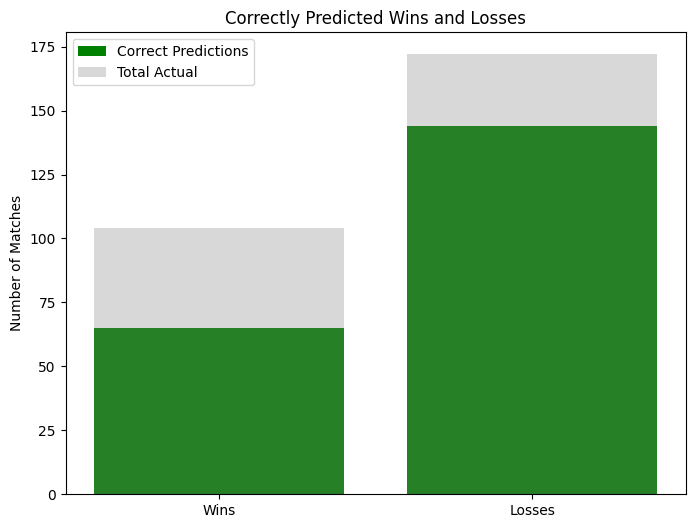

In [ ]:
cross_tab = pd.crosstab(
    index=combined_with_more_features["actual"],
    columns=combined_with_more_features["predicted"],
    rownames=['Actual'],
    colnames=['Predicted']
)
print("Cross-tabulation of actual vs predicted outcomes:")
print(cross_tab)

# Correctly predicted wins
correct_wins = combined_with_more_features[
    (combined_with_more_features["actual"] == 1) & (combined_with_more_features["predicted"] == 1)
].shape[0]
total_wins = combined_with_more_features[combined_with_more_features["actual"] == 1].shape[0]
print(f"Correctly predicted wins: {correct_wins}/{total_wins}")

# Correctly predicted losses
correct_losses = combined_with_more_features[
    (combined_with_more_features["actual"] == 0) & (combined_with_more_features["predicted"] == 0)
].shape[0]
total_losses = combined_with_more_features[combined_with_more_features["actual"] == 0].shape[0]
print(f"Correctly predicted losses: {correct_losses}/{total_losses}")

import matplotlib.pyplot as plt

# Data for the bar chart
categories = ['Wins', 'Losses']
correct_predictions = [correct_wins, correct_losses]
total_predictions = [total_wins, total_losses]

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, correct_predictions, color='green', label='Correct Predictions')
plt.bar(categories, total_predictions, color='gray', alpha=0.3, label='Total Actual')

# Add labels and title
plt.ylabel('Number of Matches')
plt.title('Correctly Predicted Wins and Losses')
plt.legend()
plt.show()



# Visualising Feature Importance

Finally, we visualise the importance of the selected features in the Random Forest model. This helps to understand which features contribute the most to the model’s predictions.

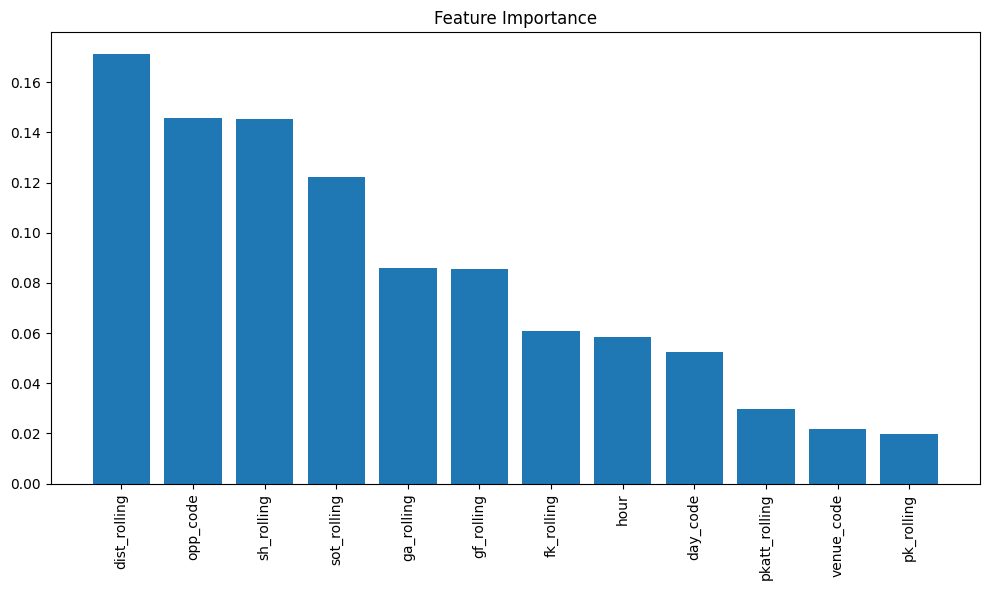

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feature names used in the model
# Assuming the predictors used in training were scaled or encoded
try:
    feature_names = rf.feature_names_in_  # For newer versions of sklearn
except AttributeError:
    feature_names = additional_predictors  # If feature_names_in_ is not available


# Now proceed to plot if the lengths match
if len(importances) == len(feature_names):
    # Sort the importances and corresponding feature names
    indices = np.argsort(importances)[::-1]  # Sort indices based on importance
    feature_names = np.array(feature_names)  # Convert to NumPy array if not already

    # Create a bar plot of feature importance
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: Number of feature names ({len(feature_names)}) does not match number of importances ({len(importances)}).")
